In [1]:
print('This is for code used in the main analysis')

This is for code used in the main analysis


In [2]:
#libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Kmeans libraries
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

[[53.35604136 -6.27203773]
 [53.34108627 -6.24685977]
 [53.34365711 -6.29759778]]


<AxesSubplot:xlabel='LATITUDE', ylabel='LONGITUDE'>

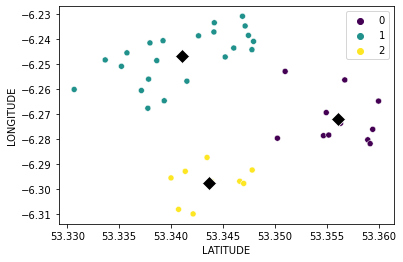

In [3]:
os.chdir("..")
# Choose stations using K-means clustering 

# Import station coordinates (pre-wrangled in R)
df = pd.read_csv("data/stations.csv")

# Filter the dataframe to include only bike stands = 40
df = df[df['BIKE.STANDS'] == 40]

# Create a subset of the dataset containing only the latitude and longitude columns
X = df[['LATITUDE', 'LONGITUDE']]

# Standardize the data
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# Apply k-means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42).fit(X_std)

# Add the cluster labels to the dataframe
df['CLUSTER'] = kmeans.labels_

# Print the centroids of each cluster
centroids = scaler.inverse_transform(kmeans.cluster_centers_)
print(centroids)

# Create a scatter plot of the data points colored by cluster
sns.scatterplot(x="LATITUDE", y="LONGITUDE",hue = 'CLUSTER', data=df, palette='viridis')

# Add the centroids to the plot as black diamonds
sns.scatterplot(x=centroids[:, 0], y=centroids[:, 1],marker='D', s=100, color='black')



In [4]:
# Find the nearest point to each cluster
distances = cdist(X, centroids, 'euclidean')
nearest_centroid_indices = np.argpartition(distances, kth=range(3))[:, :3]

# Get the nearest point to each cluster
nearest_points = []
for i in range(kmeans.n_clusters):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    nearest_point_index = np.argmin(distances[cluster_indices, i])
    nearest_point = X.iloc[cluster_indices[nearest_point_index]]
    nearest_points.append(nearest_point)

# Print the nearest point to each cluster
print(nearest_points)

[LATITUDE     53.356308
LONGITUDE    -6.273717
Name: 107, dtype: float64, LATITUDE     53.338615
LONGITUDE    -6.248606
Name: 111, dtype: float64, LATITUDE     53.343899
LONGITUDE    -6.297060
Name: 93, dtype: float64]


The above coordinates suggest that geographically well-distributed stations are: 
1. Phibsborough Road
2. Merrion Square South 
3. Royal Hospital

In [5]:
#import data
data = pd.read_csv("data/bikedata.csv")
data.head()

,Unnamed: 0,TIME,NAME,BIKE.STANDS,AVAILABLE.BIKE.STANDS,AVAILABLE.BIKES,STATUS
0,1,2018-08-01 12:30:02,ROYAL HOSPITAL,40,40,0,Open
1,2,2018-08-01 12:35:02,ROYAL HOSPITAL,40,40,0,Open
2,3,2018-08-01 12:40:02,ROYAL HOSPITAL,40,40,0,Open
3,4,2018-08-01 12:45:02,ROYAL HOSPITAL,40,40,0,Open
4,5,2018-08-01 12:50:02,ROYAL HOSPITAL,40,40,0,Open


In [6]:
#Parse dates and times
data.TIME = pd.to_datetime(data.TIME, format = "%Y-%m-%d %H:%M:%S")
data["DATE"] = pd.DatetimeIndex(data.TIME.dt.date)
data.head()
#Calculate bike usage
data["BIKE.USAGE"] = data["AVAILABLE.BIKE.STANDS"]/data["BIKE.STANDS"]
data.head()

,Unnamed: 0,TIME,NAME,BIKE.STANDS,AVAILABLE.BIKE.STANDS,AVAILABLE.BIKES,STATUS,DATE,BIKE.USAGE
0,1,2018-08-01 12:30:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
1,2,2018-08-01 12:35:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
2,3,2018-08-01 12:40:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
3,4,2018-08-01 12:45:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0
4,5,2018-08-01 12:50:02,ROYAL HOSPITAL,40,40,0,Open,2018-08-01,1.0


In [7]:
#create masks
dataPR = data[data.NAME == "PHIBSBOROUGH ROAD"]
dataMS = data[data.NAME == "MERRION SQUARE SOUTH"]
dataRH = data[data.NAME == "ROYAL HOSPITAL"]

#Calculate weekly average usage
PR_weekly_avg = dataPR.groupby(pd.Grouper(key='DATE', freq='W'))['BIKE.USAGE'].mean()
PR_date_vector = pd.DatetimeIndex(dataPR["DATE"].dt.date)

MS_weekly_avg = dataMS.groupby(pd.Grouper(key='DATE', freq='W'))['BIKE.USAGE'].mean()
MS_date_vector = pd.DatetimeIndex(dataMS["DATE"].dt.date)

RH_weekly_avg = dataRH.groupby(pd.Grouper(key='DATE', freq='W'))['BIKE.USAGE'].mean()
RH_date_vector = pd.DatetimeIndex(dataRH["DATE"].dt.date)